In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
image_folder = "/content/drive/MyDrive/ImagesRAG"


In [3]:
!pip install transformers faiss-cpu pillow matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 46.0 MB/s eta 0:00:00


In [4]:
import os
import torch
import faiss
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from transformers import CLIPProcessor, CLIPModel


In [5]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

model.eval()


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/398 [00:00<?, ?it/s]

CLIPModel LOAD REPORT from: openai/clip-vit-base-patch32
Key                                  | Status     |  | 
-------------------------------------+------------+--+-
text_model.embeddings.position_ids   | UNEXPECTED |  | 
vision_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

The image processor of type `CLIPImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05,

In [11]:
image_embeddings = []
image_paths = []

for file in os.listdir(image_folder):
    if file.endswith(('.jpg', '.png', '.jpeg')):
        path = os.path.join(image_folder, file)

        image = Image.open(path).convert('RGB')
        inputs = processor(images=image, return_tensors='pt')

        with torch.no_grad():
            embedding = model.get_image_features(**inputs)

        # Correctly access the pooler_output from the BaseModelOutputWithPooling object
        image_embeddings.append(embedding.pooler_output.squeeze().numpy())
        image_paths.append(path)

image_embeddings = np.array(image_embeddings)
print('Total images indexed:', len(image_embeddings))

Total images indexed: 17


In [12]:
# The embeddings should now be correctly shaped (num_images, 512) from the previous cell.
dimension = image_embeddings.shape[1]

index = faiss.IndexFlatL2(dimension)
index.add(image_embeddings)

print("FAISS index created!")

FAISS index created!


In [31]:

def search_images(query, k=3):
    # Prepare text input
    inputs = processor(text=[query], return_tensors="pt", padding=True, truncation=True)

    with torch.no_grad():
        text_outputs = model.get_text_features(**inputs)

    # 🔴 Some versions return tensor, some return object → handle both
    if isinstance(text_outputs, torch.Tensor):
        text_embedding = text_outputs
    else:
        # fallback if wrapped output
        text_embedding = text_outputs.pooler_output

    # Convert to numpy
    text_embedding = text_embedding.detach().cpu().numpy().astype("float32")

    # Normalize same as image embeddings
    faiss.normalize_L2(text_embedding)

    # Search
    distances, indices = index.search(text_embedding, k)

    results = [image_paths[i] for i in indices[0]]
    return results


In [32]:
image_embeddings = np.vstack(image_embeddings).astype("float32")
faiss.normalize_L2(image_embeddings)


In [33]:
index = faiss.IndexFlatIP(image_embeddings.shape[1])
index.add(image_embeddings)


['/content/drive/MyDrive/ImagesRAG/images (2).jpg', '/content/drive/MyDrive/ImagesRAG/download (2).jpg', '/content/drive/MyDrive/ImagesRAG/download.jpg']


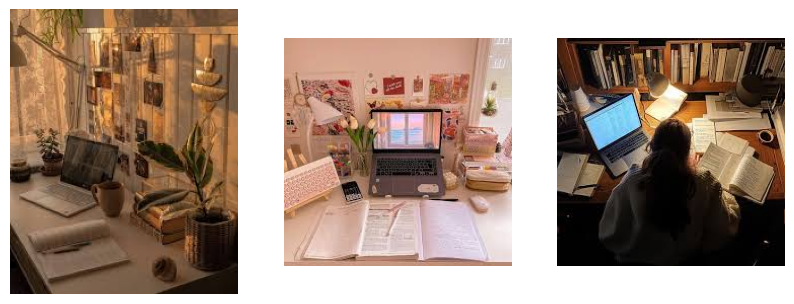

In [34]:
results = search_images("study table", k=3)
print(results)
show_results(results)



Query: study table


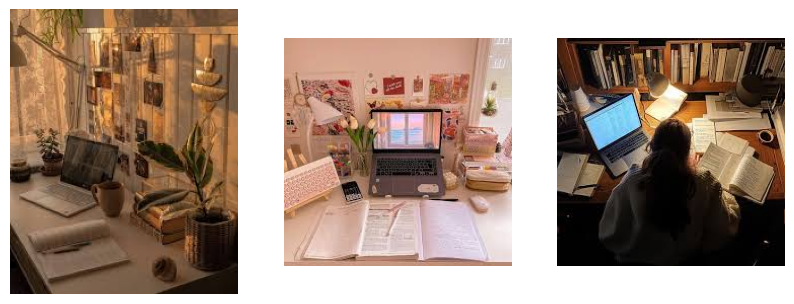


Query: working on laptop


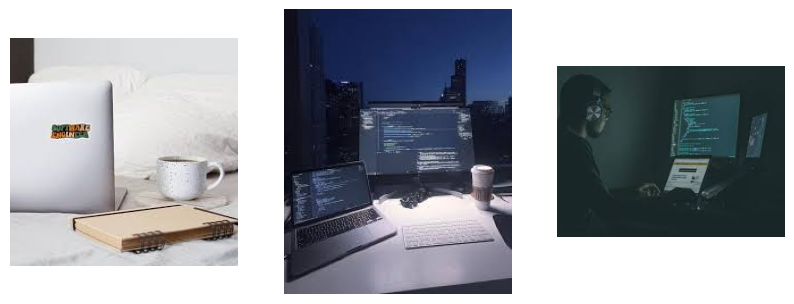


Query: books and notes


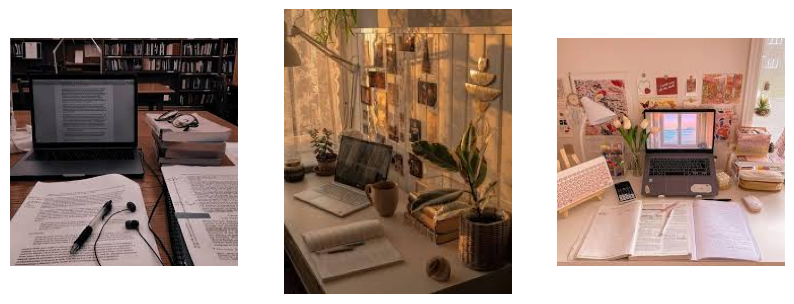


Query: personal workspace


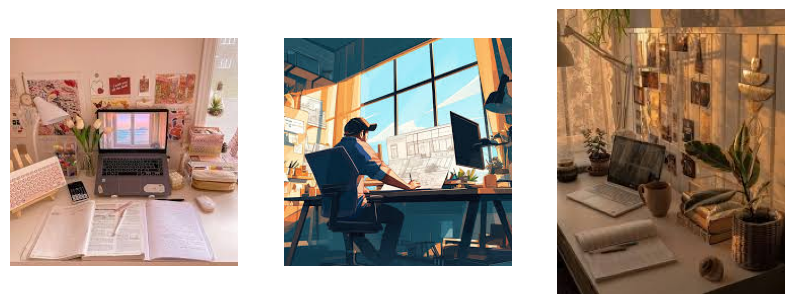

In [35]:
queries = [
    "study table",
    "working on laptop",
    "books and notes",
    "personal workspace"
]

for q in queries:
    print("\nQuery:", q)
    results = search_images(q, k=3)
    show_results(results)


## Intelligent Image Search using RAG

In this project, a Retrieval-Augmented Generation (RAG) pipeline was built
using a personal image dataset (17 images).

### Steps:
1. Collected personal images from internet.
2. Generated semantic embeddings using CLIP model.
3. Stored embeddings in FAISS vector database.
4. Queried the system using natural language.
5. Retrieved visually relevant images based on meaning.

### Outcome:
The system successfully performs semantic image search without relying on filenames.
This demonstrates how Multimodal RAG can be applied to:
- Smart photo search
- Personal knowledge retrieval
- AI-powered gallery management
